In [1]:
%matplotlib inline
from context import ionsim
import autograd.numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from ipywidgets import interact
from scipy.constants import *

rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = (8.0, 6.0)
rcParams['font.size'] = 14
rcParams['axes.labelsize'] = 18
rc('animation', html='html5')

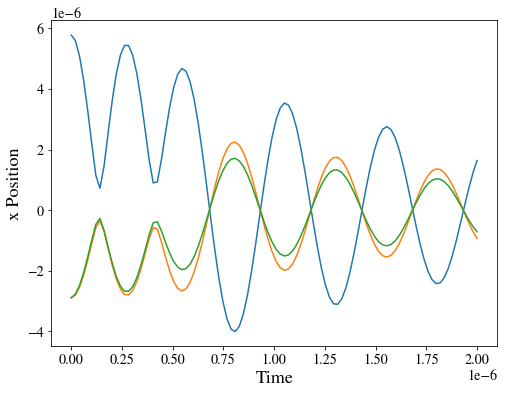

In [2]:
# define a class inherited from ionsim that has an optical standing wave potential
class optical_lattice(ionsim.IonSim):
    # laser wavelength
    wl = 1064 * 1e-9
    # AC stark shift
    alpha0 = -3.697 * 0.0001  # Hz/(W/m^2)
    # laser waist
    w0 = 40e-6  # m
    # laser power
    P0 = 5000  # W

    # quadrupole frequency
    f_r = 2e6  # Hz

    # initial N ions to self.x0 in a circle of radius d, with velocities according to temperature T
    def init_ions(self, N=3, d=10e-6, T=3e-3):
        r = d/np.sqrt(2-2*np.cos(2*pi/3))
        theta = 2*pi*np.arange(N)/N
        
        self.x0 = np.zeros((6, N))
        self.x0[0, :] = r*np.cos(theta)
        self.x0[1, :] = r*np.sin(theta)
        self.x0[2, :] = np.zeros(N)
        sigma_v = np.sqrt(k * T / self.m)
        self.x0[3:6, :] = np.random.normal(0, sigma_v, (3, N))
        
    # electrostatic quadrupole potential with radial frequency f_r
    def U_quadrupole(self, x, y, z, t=0):
        return (1 / 2) * self.m * (2 * pi * self.f_r)**2 * (x**2 + y**2 - 2 * z**2)

    # optical standing wave potential with waist, power, and wavelength
    def U_optical(self, x, y, z, t=0):
        zR = (pi * self.w0**2 / self.wl)
        wz = self.w0 * np.sqrt(1 + (z / zR)**2)
        U0 = (8 * self.P0 / (pi) * self.alpha0 * h)
        k = (2 * pi / self.wl)
        return (U0 / wz**2) * np.cos(k * z)**2 * np.exp(-(x**2 + y**2) / wz**2)

    # total user defined potential, the sum of the quadrupole and optical standing wave
    def U(self, x, y, z, t=0):
        return self.U_quadrupole(x, y, z, t) + self.U_optical(x, y, z, t)
    
# create a simulation class object
s = optical_lattice()
# initialize it with 3 ions
s.init_ions(N=3)

# turn on damping and integrate for 2us. This isn't necessary, but it's nice to make sure things make sense.
s.gamma = np.ones(3) * 1e6 * s.m
t = np.linspace(0, 2e-6, 100)
s.run(t)
ionsim.plot(s)

In [3]:
# solve for equilibrium positions using initial positions as a guess
x_eq = s.equilibrium_position(*s.x0[0:3,:])

# create an interactive plot of normal mode vectors and frequencies
@interact(i=(0,5))
def plot_normal_modes(i=0):
    ionsim.plot_normal_modes(s, x_eq, i=i)